Проект e-commerce: вариант 1 
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?  

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.  
6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

 olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (в идеальных данных не может быть двух пользователей с одинаковым значением, является уникальным айдишником пользователя)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя



olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки



olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа (не содержит информацию о количестве товаров)

product_id —  уникальный идентефикатор товара (аналог штрихкода)

seller_id — уникальный идентефикатор производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара


Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt

import numpy as np
from textwrap import wrap

In [2]:
customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-potapejko/apotapeiko/olist_customers_dataset.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-potapejko/apotapeiko/olist_orders_dataset.csv')
items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-potapejko/apotapeiko/olist_order_items_dataset.csv')

Мерджим customers и orders и items разными группами

In [3]:
cus_and_ord = customers.merge(orders, on=['customer_id', 'customer_id'])

In [4]:
items_w_dates = items.merge(orders, on=['order_id', 'order_id'])

### 1. Сколько у нас пользователей, которые совершили покупку только один раз?

#### В этой и последующих задачах, где нужно посчитать покупки, за совершенную покупку предлагаю считать все заказы, которые в статусах: 
#processing - т.к. заказ уже оплачен
#shipped - тоже самое
#delivered - очевидно. 

Важно: есть около 10 заказов со статусом delivered, но без даты доставки
при этом есть около 300-400 заказов, которые со статусом shipped, delivered, но с датой доставки. 
Их не убрал, но это обсуждаемо с постановщиком задачи. 

In [5]:
cus_and_ord \
    .query("order_status not in ('invoiced', 'processing', 'unavailable', 'canceled', 'created')") \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'quant_orders_per_customer'}) \
    .sort_values('quant_orders_per_customer', ascending=False) \
    .query("quant_orders_per_customer == 1") \
    .shape

(91540, 2)

### Ответ: пользователей совершивших только 1 заказ 91540

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

##### Из всех статусов заказа за 100% недоставленные предлагаю считать только отмененные и недоступные. Остальные статусы предполагают,что заказ еще может быть доставлен

In [6]:
#Создаем новую колонку на начало месяца из колонки создания заказа
orders['order_month'] = orders['order_purchase_timestamp'].to_numpy().astype('datetime64[M]')

In [7]:
orders \
    .query("order_status in ('canceled', 'unavailable')") \
    .groupby(['order_status', 'order_month'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'notdeliv_q'}) \
    .groupby(['order_status'], as_index=False) \
    .agg({'notdeliv_q': 'mean'}) \
    .round(0)

,order_status,notdeliv_q
0,canceled,26.0
1,unavailable,29.0


### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

##### Предлагаю за покупку брать в этом случае желаение покупателя купить, а значит каждый оформленный заказ, независимо от дальнейшей судьбы заказа

In [8]:
#Переводим колонку с временем создания заказа к нужному формату
items_w_dates['order_purchase_timestamp'] = pd.to_datetime(items_w_dates['order_purchase_timestamp'])

In [9]:
#Создаем новую колонку с номером недели
items_w_dates['day_of_week'] = items_w_dates['order_purchase_timestamp'].dt.day_name()

In [10]:
#Отфильруем по общему количеству покупок в каждый из дней недели не менее 10, чтобы выборка была более репрезентативна
products_per_week = items_w_dates \
    .query("order_status in ('processing', 'shipped', 'delivered')") \
    .groupby(['product_id', 'day_of_week'], as_index=False) \
    .agg({'order_status': 'count'}) \
    .query("order_status > 9") \
    .groupby(['product_id', 'day_of_week'], as_index=False) \
    .agg({'order_status': 'max'}) \
    .rename(columns={'order_status': 'max_orders_per_w'}) \
    .sort_values('max_orders_per_w', ascending=False) \
    .groupby(['product_id'], as_index=False).head(1)

In [11]:
#Итоговый DF
products_per_week

,product_id,day_of_week,max_orders_per_w
239,422879e10f46682990de24d770e7f83d,Wednesday,93
584,99a4788cb24856965c36a24e339b6058,Monday,92
645,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
336,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
201,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...
156,3225c54bb2785c33f49f50398fcdb88c,Friday,10
799,d5b703c271f43f9c588a6f512a00f77e,Thursday,10
807,db5efde3ad0cc579b130d71c4b2db522,Thursday,10
813,dc52f0f5d3ec37a93eaf956cde4e5d2c,Thursday,10


### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [12]:
cus_and_ord['order_month'] = cus_and_ord['order_purchase_timestamp'].to_numpy().astype('datetime64[M]')

In [13]:
buys_per_month_per_user = cus_and_ord \
    .query("order_status in ('processing', 'shipped', 'delivered')") \
    .groupby(['customer_unique_id', 'order_month'], as_index=False) \
    .agg({'customer_city': 'count'}) \
    .rename(columns={'customer_city': 'q_buys'}) \
    .sort_values('q_buys', ascending = False)

In [14]:
buys_per_month_per_user['days_in_month'] = buys_per_month_per_user['order_month'].dt.days_in_month 

In [15]:
buys_per_month_per_user['days_in_week'] = (buys_per_month_per_user['days_in_month'] / 7).round(2)

In [16]:
buys_per_month_per_user['mean_buys_per_week'] = (buys_per_month_per_user['q_buys'] / buys_per_month_per_user['days_in_week']).round(2)

In [17]:
mean_buys_per_week = buys_per_month_per_user[['customer_unique_id', 'order_month', 'mean_buys_per_week']]

In [18]:
#Итоговый DFс разбивкой по уникам и месяцам. 
#Бесполезный с точки зрения выводов ДФ, как по мне
mean_buys_per_week

,customer_unique_id,order_month,mean_buys_per_week
7214,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,1.35
68340,b4e4f24de1e8725b74e4a1f4975116ed,2018-02-01,1.00
23576,3e43e6105506432c953e165fb2acf44c,2018-02-01,1.00
61252,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,1.00
75634,c8460e4251689ba205045f3ea17884a1,2018-08-01,0.90
...,...,...,...
32364,559a8ee3945ef2efb08cf74e36c8b747,2018-04-01,0.23
32363,559a5f67ea052226bb24ee8da93df761,2018-01-01,0.23
32362,5599df2eeb9e2e4f377db24e09cb976f,2017-10-01,0.23
32361,5598995788d932aa2a2db20d45187139,2018-03-01,0.23


### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

In [19]:
cus_and_ord = cus_and_ord.rename(columns={'order_month': 'TransactionMonth'})

In [20]:
cus_and_ord['order_day'] = cus_and_ord['order_purchase_timestamp'].to_numpy().astype('datetime64[D]')

In [21]:
cohort = cus_and_ord.loc[(cus_and_ord['order_day'] >= '2017-01-01') &  (cus_and_ord['order_day'] <= '2017-12-31')]

In [22]:
cohort = cohort.query("order_status in ('processing', 'shipped', 'delivered')")

In [23]:
cohort = cohort[['customer_unique_id', 'order_id', 'TransactionMonth', 'order_day']]

In [24]:
cohort.set_index('customer_unique_id', inplace=True)

In [25]:
cohort['CohortMonth']=cohort.groupby(level=0)['TransactionMonth'].min()

In [26]:
cohort.reset_index(inplace=True)

In [27]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Получение целых чисел для частей даты
transcation_year, transaction_month, _ = get_date_int(cohort, 'TransactionMonth')
cohort_year, cohort_month, _ = get_date_int(cohort, 'CohortMonth')

In [28]:
#  Получаем разницу в годах
years_diff = transcation_year - cohort_year

# Считаем разницу в месяцах
months_diff = transaction_month - cohort_month


#Извлечем разницу в месяцах из всех предыдущих значений
#В конце добавлено «+1», поэтому первый месяц помечен как 1 вместо 0 для облегчения интерпретации.


cohort['CohortIndex'] = years_diff * 12 + months_diff  + 1 
print(cohort.head(5))

                 customer_unique_id                          order_id  \
0  861eff4711a542e4b93843c6dd7febb0  00e7ee1b050b8499577073aeb2a297a1   
1  4c93744516667ad3b8f1fb645a3116a4  5741ea1f91b5fbab2bd2dc653a5b5099   
2  57b2a98a409812fe9618067b6b8ebe4f  1093c8304c7a003280dd34598194913d   
3  2a7745e1ed516b289ed9b29c7d0539a5  8428e578bb1cf839ae26a6b7615502b9   
4  918dc87cd72cd9f6ed4bd442ed785235  83d8f70418eefd96f37b483dff430305   

  TransactionMonth  order_day CohortMonth  CohortIndex  
0       2017-05-01 2017-05-16  2017-05-01            1  
1       2017-09-01 2017-09-14  2017-09-01            1  
2       2017-11-01 2017-11-16  2017-11-01            1  
3       2017-11-01 2017-11-27  2017-11-01            1  
4       2017-09-01 2017-09-09  2017-09-01            1  


In [29]:
# Подсчет ежедневного активного пользователя с каждой когорты
grouping = cohort.groupby(['CohortMonth', 'CohortIndex'])



# Подсчет количества уникальных идентификаторов клиентов, попадающих в каждую группу CohortMonth и CohortIndex
cohort_data = grouping['customer_unique_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()


 # Присвоение имен столбцов фрейму данных, созданному выше
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                 columns ='CohortIndex',
                                 values = 'customer_unique_id')

In [30]:
print(cohort_counts.round(1))

CohortIndex      1     2     3     4     5     6     7    8    9    10   11  \
CohortMonth                                                                   
2017-01-01    741.0   3.0   2.0   1.0   3.0   1.0   3.0  1.0  1.0  NaN  3.0   
2017-02-01   1678.0   4.0   5.0   2.0   7.0   2.0   4.0  3.0  2.0  3.0  2.0   
2017-03-01   2568.0  13.0   9.0  10.0   9.0   4.0   4.0  8.0  9.0  2.0  NaN   
2017-04-01   2311.0  14.0   5.0   4.0   7.0   6.0   8.0  7.0  7.0  NaN  NaN   
2017-05-01   3525.0  17.0  17.0  14.0  11.0  12.0  15.0  5.0  NaN  NaN  NaN   
2017-06-01   3094.0  14.0  11.0  12.0   8.0  11.0  11.0  NaN  NaN  NaN  NaN   
2017-07-01   3816.0  20.0  13.0   9.0  11.0   8.0   NaN  NaN  NaN  NaN  NaN   
2017-08-01   4112.0  28.0  14.0  11.0  15.0   NaN   NaN  NaN  NaN  NaN  NaN   
2017-09-01   4061.0  28.0  22.0  12.0   NaN   NaN   NaN  NaN  NaN  NaN  NaN   
2017-10-01   4378.0  31.0  11.0   NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN   
2017-11-01   7156.0  40.0   NaN   NaN   NaN   NaN   

In [31]:
# Выберем первый столбец и сохраним его в cohort_sizes как размер когорты - не активный клиент в первый день
# Мы будем хранить 1-й столбец как размер группы, т.е. общее количество клиентов в этой группе.


cohort_sizes = cohort_counts.iloc[:,0]

#Разделим значения в других столбцах на размер когорты, чтобы рассчитать коэффициент удержания, 
#т.е. количество клиентов в индексе каждой когорты.

retention = cohort_counts.divide(cohort_sizes, axis=0)

In [32]:
retention.round(3)*10

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2017-01-01,10.0,0.04,0.03,0.01,0.04,0.01,0.04,0.01,0.01,NaN,0.04,0.01
2017-02-01,10.0,0.02,0.03,0.01,0.04,0.01,0.02,0.02,0.01,0.02,0.01,NaN
2017-03-01,10.0,0.05,0.04,0.04,0.04,0.02,0.02,0.03,0.04,0.01,NaN,NaN
2017-04-01,10.0,0.06,0.02,0.02,0.03,0.03,0.03,0.03,0.03,NaN,NaN,NaN
2017-05-01,10.0,0.05,0.05,0.04,0.03,0.03,0.04,0.01,NaN,NaN,NaN,NaN
2017-06-01,10.0,0.05,0.04,0.04,0.03,0.04,0.04,NaN,NaN,NaN,NaN,NaN
2017-07-01,10.0,0.05,0.03,0.02,0.03,0.02,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,10.0,0.07,0.03,0.03,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,10.0,0.07,0.05,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


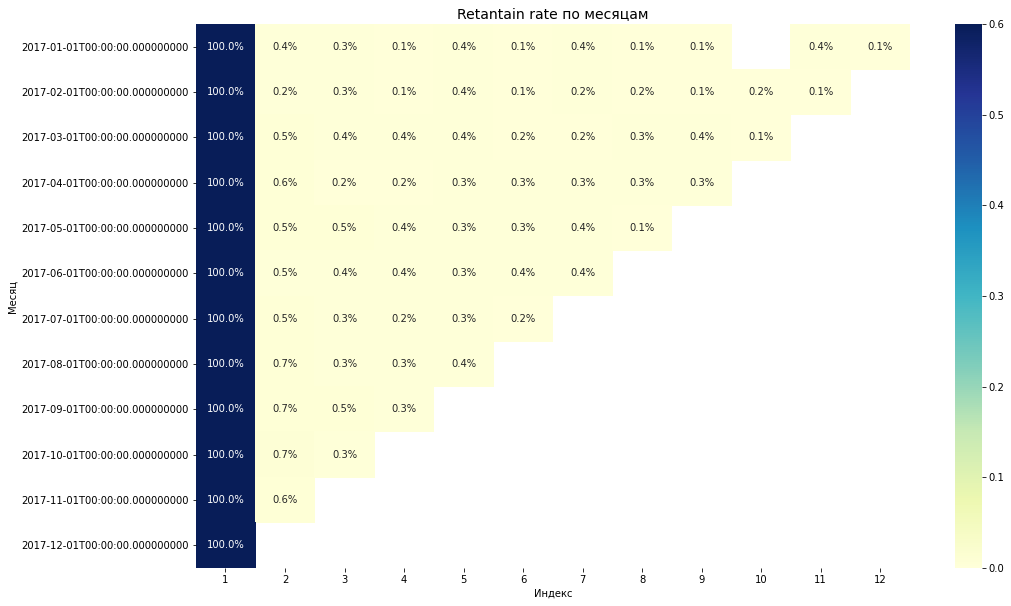

In [33]:
plt.figure(figsize=(16, 10))

plt.title('Retantain rate по месяцам', fontsize = 14)

sns.heatmap(retention, annot=True, fmt= '.1%',cmap='YlGnBu', vmin = 0.0 , vmax = 0.6)
plt.ylabel('Месяц')
plt.xlabel('Индекс')
plt.yticks( rotation='360')
plt.show()

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.ер, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [34]:
rfm_total = cus_and_ord.merge(items, on=['order_id', 'order_id'])

In [35]:
rfm_total['order_purchase_timestamp']= pd.to_datetime(rfm_total['order_purchase_timestamp'])

In [36]:
rfm_total = rfm_total.query("order_status in ('processing', 'shipped', 'delivered')")

In [37]:
rfm_almost = rfm_total[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'order_item_id', 'product_id', 'price']]

In [38]:
monetary_raw = rfm_almost \
    .groupby(['customer_unique_id', 'product_id', 'price'], as_index=False) \
    .agg({'order_item_id': 'nunique'}) \
    .rename(columns={'order_item_id': 'quantity_prod_per_user'})

In [39]:
monetary_raw['sum_total'] = monetary_raw.price * monetary_raw.quantity_prod_per_user

In [40]:
monetary = monetary_raw.groupby('customer_unique_id')['sum_total'].sum().reset_index()

In [41]:
frequency = rfm_almost \
    .groupby(['customer_unique_id'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .sort_values('order_id', ascending=False) \
    .rename(columns={'order_id': 'quantity_orders_per_user'})

In [42]:
recency = rfm_almost.groupby('customer_unique_id')['order_purchase_timestamp'].max().to_frame().reset_index()
recency = recency.rename(columns={'order_purchase_timestamp': 'last_purchase'})

In [43]:
recency['last_purchase'] = recency['last_purchase'].to_numpy().astype('datetime64[D]')

In [44]:
now = dt.datetime.today()
recency['recency'] = recency['last_purchase'].apply(lambda x: (now - x).days)

In [45]:
rfm = recency.merge(monetary,on='customer_unique_id').merge(frequency,on='customer_unique_id')

In [46]:
rfm = rfm.rename(columns={'recency': 'Recency', 
                                        'sum_total': 'Monetary',
                                        'quantity_orders_per_user': 'Frequency'})

In [47]:
rfm = rfm[['customer_unique_id', 'Recency', 'Monetary', 'Frequency']]

In [48]:
quintiles = rfm[['Recency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 1639.0, 0.4: 1724.0, 0.6: 1815.0, 0.8: 1930.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

In [49]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
    
# по частотности - определили границе в ячейке выше (1 визит - рейтинг 1, 5+ визитов - 5)
def f_score(x):
    if x <= 1:
        return 1
    elif x <= 2:
        return 2
    elif x <= 3:
        return 3
    elif x <= 4:
        return 4
    else:
        return 5 
    
def m_score(x):
    if x <= quintiles['Monetary'][.2]:
        return 1
    elif x <= quintiles['Monetary'][.4]:
        return 2
    elif x <= quintiles['Monetary'][.6]:
        return 3
    elif x <= quintiles['Monetary'][.8]:
        return 4
    else:
        return 5    

In [50]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['Monetary'].apply(lambda x: m_score(x))

In [51]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

In [52]:
segt_map = {
    r'[1-2][1-2]': 'Спят',
    r'[1-2][3-4]': 'В риске',
    r'[1-2]5': 'Нельзя потерять',
    r'3[1-2]': 'Почти спят',
    r'33': 'Нужно взбодрить',
    r'[3-4][4-5]': 'Лояльные',
    r'41': 'Перспективные',
    r'51': 'Новые',
    r'[4-5][2-3]': 'Потенциал лояльных',
    r'5[4-5]': 'Чемпионы'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,Recency,Monetary,Frequency,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,1658,129.90,1,4,1,4,414,Перспективные
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1661,18.90,1,4,1,1,411,Перспективные
2,0000f46a3911fa3c0805444483337064,2084,69.00,1,1,1,2,112,Спят
3,0000f6ccb0745a6a4b88665a16c9f078,1868,25.99,1,2,1,1,211,Спят
4,0004aac84e0df4da2b147fca70cf8255,1835,180.00,1,2,1,5,215,Спят


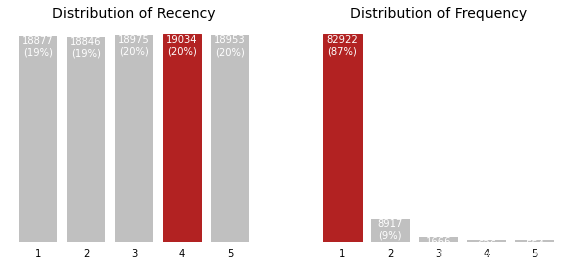

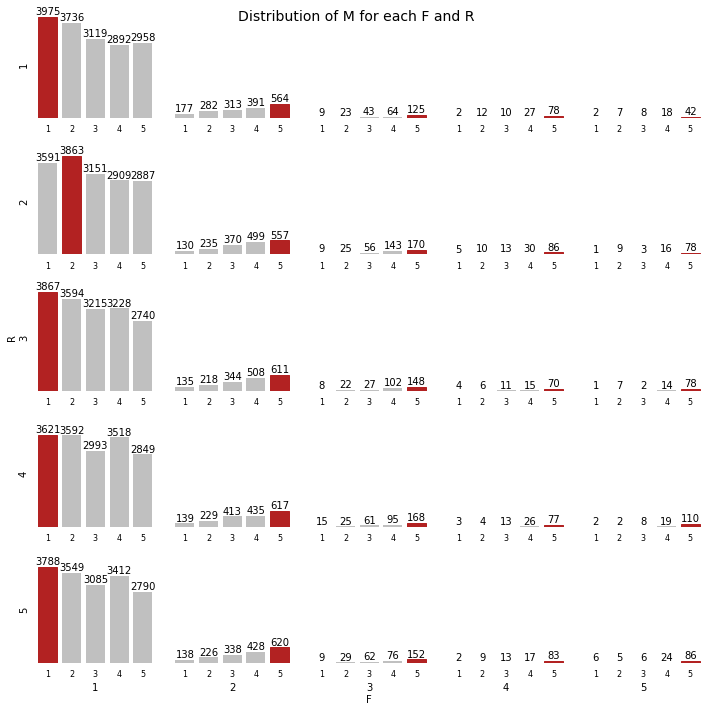

In [53]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

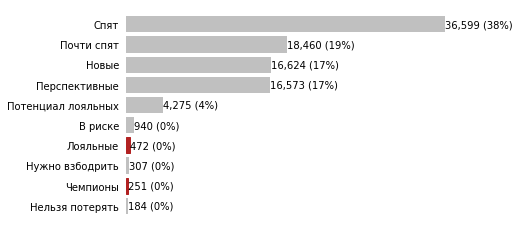

In [54]:
# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Чемпионы', 'Лояльные']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [55]:
#в итоговом анализе я не стал отсеивать каким-либо образом пользователей, т.к. наша задача оценить текущую собранную аудиторию
#и по итогу мы ожидаемо получили, что большая часть людей находится во сне (даже учитывая что последняя покупка было совершена в
#2018 году)
#Далее задача проработать каждую группу по собственному сценарию и регулярно (раз в квартал, пол года, год) оценивать текущую аудиторию